In [16]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Masking,Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed,MaxPooling1D, Flatten, Conv1D,Conv2D,Dropout, MaxPooling2D, GRU # for creating layers inside the Neural Network
from keras.optimizers import Adam , SGD
from keras import metrics
from keras.utils import plot_model
# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import numpy.ma as ma
# Sklearn
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for feature scaling
from sklearn.model_selection import train_test_split
# Visualization
import plotly 
import plotly.express as px
import plotly.graph_objects as go
print('plotly: %s' % plotly.__version__) # print version
from matplotlib import pyplot as plt

#file accessing
import os
# time stuff
from datetime import timedelta
import calendar


Tensorflow/Keras: 2.9.0
pandas: 1.4.2
numpy: 1.22.4
sklearn: 1.1.1
plotly: 5.9.0


In [17]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against the training feature and label."""

  # Label the axes.
  plt.xlabel("feature")
  plt.ylabel("label")

  # Plot the feature values vs. label values.
  plt.scatter(feature, label)

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = feature[-1]
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()

def plot_the_loss_curve(epochs, rmse):
  """Plot the loss curve, which shows loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")
  #epochs.remove(max(epochs))
  
  #rmse.drop(max(rmse))
  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([min(rmse)*0.97, max(rmse)])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


##### Read from file and establish dataframe and future functions

In [18]:
df=pd.read_csv('InSAR_data_south/displacement/export_dataframe1.csv')
df=df.set_index([df.columns[0],df.columns[1]])
df.columns=pd.to_datetime(df.columns, format='%Y%m%d')
df=df.dropna(axis=0, how='all')#drop full nan rows

##### Remove next line to include all data

In [19]:

#df=df.iloc[100000:500000] #cuts data to long 120-119 approx
#df=df.iloc[200000:200050]
df=df.iloc[120000:121000]

df

2014-11-08  2014-12-02  2014-12-26  2015-02-12  \
Longitude Latitude                                                   
-120.5287 35.3850          0.0     -10.730     -1.2358    -0.71533   
          35.3870          0.0     -10.641     -1.2125    -0.66436   
          35.3890          0.0     -10.652     -1.2257    -0.59206   
          35.3910          0.0     -10.571     -1.1859    -0.54365   
          35.3930          0.0     -10.540     -1.1864    -0.57563   
...                        ...         ...         ...         ...   
-120.5267 34.8609          0.0     -16.858     -3.8780         NaN   
          34.8629          0.0     -16.929     -4.1523         NaN   
          34.8649          0.0     -16.978     -3.8971         NaN   
          34.8669          0.0     -17.060     -3.9687         NaN   
          34.8689          0.0     -17.126     -4.2491         NaN   

                    2015-03-08  2015-04-01  2015-04-25  2015-05-19  \
Longitude Latitude                                                   
-120.5287 35.3850      -2.5669     -2.8853     -4.8845     -1.4449   
          35.3870      -2.5908     -2.8389     -4.8826     -1.4444   
          35.3890      -2.5869     -2.9314     -4.9469     -1.5402   
          35.3910      -2.5515     -2.8652     -4.8772     -1.4497   
          35.3930      -2.6055     -2.9910     -5.0036     -1.5842   
...                        ...         ...         ...         ...   
-120.5267 34.8609      -4.5782     -4.0853     -9.3754     -4.4968   
          34.8629      -4.7417     -4.3077     -9.5834     -4.7127   
          34.8649      -4.4842     -4.0727     -9.3444     -4.4547   
          34.8669      -4.5748     -4.1150     -9.4046     -4.4863   
          34.8689      -4.7413     -4.3139     -9.6441     -4.6737   

                    2015-06-12  2015-07-06  ...  2018-10-18  2018-10-30  \
Longitude Latitude                          ...                           
-120.5287 35.3850      -2.6790   -0.074493  ...     -8.4332     -6.1473   
          35.3870      -2.6883   -0.071874  ...     -9.0533     -6.7852   
          35.3890      -2.7329   -0.053922  ...     -8.3268     -6.0873   
          35.3910      -2.6796    0.032237  ...     -8.6760     -6.4492   
          35.3930      -2.8635   -0.151480  ...     -8.6378     -6.4279   
...                        ...         ...  ...         ...         ...   
-120.5267 34.8609      -5.0860   -1.335600  ...     -9.6967     -6.8216   
          34.8629      -5.2842   -1.559500  ...     -9.9142     -7.0563   
          34.8649      -5.0005   -1.304300  ...     -9.8293     -6.9718   
          34.8669      -5.0413   -1.386000  ...     -9.8200     -6.9705   
          34.8689      -5.2329   -1.584000  ...    -10.4000     -7.5726   

                    2018-11-11  2018-11-17  2018-11-23  2018-12-05  \
Longitude Latitude                                                   
-120.5287 35.3850      -6.7993     -7.1569     -9.6598     -11.040   
          35.3870      -7.4212     -7.7779    -10.2810     -11.599   
          35.3890      -6.7238     -7.0569     -9.5797     -10.909   
          35.3910      -7.0647     -7.3800     -9.9036     -11.229   
          35.3930      -7.0139     -7.3224     -9.8620     -11.172   
...                        ...         ...         ...         ...   
-120.5267 34.8609      -8.4102    -10.8840    -11.8290     -12.897   
          34.8629      -8.5876    -11.0670    -11.9990     -13.061   
          34.8649      -8.4271    -10.9730    -11.8730     -13.014   
          34.8669      -8.3962    -10.9700    -11.8280     -12.899   
          34.8689      -8.9573    -11.5910    -12.4610     -13.465   

                    2018-12-17  2018-12-29  2019-01-10  2019-01-22  
Longitude Latitude                                                  
-120.5287 35.3850      -7.0263     -5.8773     -5.6599     -5.9405  
          35.3870      -7.5750     -6.4959     -6.2671     -6.5752  
          35.3890      -6.8630     

In [20]:
df2=pd.read_csv('InSAR_data_south/displacement/groundwater.csv')
df2=df2.set_index([df2.columns[0],df2.columns[1]])
df2.columns=pd.to_datetime(df2.columns, format='%Y-%m-%d')
df2=df2.dropna(axis=0, how='all')#drop full nan rows
for y in range(df.columns.size):# includes all dates and adds nans
    if df.columns[y] != df2.columns[y]: #if column is misssing insert it
        df2.insert(loc=y,column=df.columns[y],value=np.nan*11286,allow_duplicates=False)
df2.index[0]
type(df2.index[0])


tuple

In [21]:
df2.index.size


11286

In [22]:
for x in range(df2.index.size): #for each row
    curr=np.nan
    for y in range(df2.columns.size): #for each value in the row
        n=0
        while np.isnan(curr): # if saved value is empty
            curr=df2.iloc[x].values[n] #look for next actual value
            n+=1
        if np.isnan(df2.iloc[x].values[y]):#if data is nan then replace with previous curr value
            df2.iat[x,y]=curr
            #df2.iloc[x].values[y]=curr
        else:
            curr= df2.iloc[x].values[y]
                

df2

,,2014-11-08,2014-12-02,2014-12-26,2015-02-12,2015-03-08,2015-04-01,2015-04-25,2015-05-19,2015-06-12,2015-07-06,...,2018-10-18,2018-10-30,2018-11-11,2018-11-17,2018-11-23,2018-12-05,2018-12-17,2018-12-29,2019-01-10,2019-01-22
Longitude,Latitude,,,,,,,,,,,,,,,,,,,,,
-120.9486,37.6316,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,...,75.653992,75.813688,75.973384,76.0,76.0,76.0,76.0,76.0,76.0,76.0
-120.8926,36.7114,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,...,75.200000,75.200000,75.200000,75.2,75.2,75.2,75.2,75.2,75.2,75.2
-120.8846,36.6994,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,...,75.200000,75.200000,75.200000,75.2,75.2,75.2,75.2,75.2,75.2,75.2
-120.8746,36.6874,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,72.248964,...,75.200000,75.200000,75.200000,75.2,75.2,75.2,75.2,75.2,75.2,75.2
-120.1368,35.6991,141.123387,141.123387,141.123387,141.123387,141.123387,141.123387,141.123387,141.123387,141.123387,141.123387,...,150.898190,151.000000,151.000000,151.0,151.0,151.0,151.0,151.0,151.0,151.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-119.0351,36.3933,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,...,16.978182,17.000000,17.000000,17.0,17.0,17.0,17.0,17.0,17.0,17.0
-119.0271,36.3793,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,...,16.978182,17.000000,17.000000,17.0,17.0,17.0,17.0,17.0,17.0,17.0
-119.0571,36.4493,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,17.409091,...,16.978182,17.000000,17.000000,17.0,17.0,17.0,17.0,17.0,17.0,17.0


In [23]:
df3=pd.read_csv('InSAR_data_south/displacement/rainfall.csv')
df3=df3.set_index([df3.columns[0],df3.columns[1]])
df3.columns=pd.to_datetime(df3.columns, format='%Y-%m-%d')
df3=df3.dropna(axis=0, how='all')#drop full nan rows
df3

,,2016-01-14,2016-01-26,2016-02-07,2016-02-19,2016-03-02,2016-03-14,2016-03-26,2016-04-07,2016-04-19,2016-05-01,...,2018-10-18,2018-10-30,2018-11-11,2018-11-17,2018-11-23,2018-12-05,2018-12-17,2018-12-29,2019-01-10,2019-01-22
Longitude,Latitude,,,,,,,,,,,,,,,,,,,,,
-120.9486,37.6316,35.932140,47.716825,21.118561,11.506145,0.546500,80.057809,8.842744,0.007399,10.204963,5.614656,...,1.002529e-08,5.244156e-15,3.241600e-13,0.0,19.307816,64.067047,31.963058,25.633082,28.319157,59.736828
-120.8926,36.7114,57.942574,70.295660,13.013996,6.237113,0.000000,61.595146,2.988674,0.990153,30.109197,8.363980,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.529937,41.590660,20.704192,29.202840,14.592794,11.388287
-120.8846,36.6994,58.567454,70.644388,12.755905,6.166043,0.000000,61.929453,2.828551,0.968460,30.476500,8.281263,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.653009,42.319168,20.722277,29.526450,14.602126,11.487171
-120.8746,36.6874,59.117970,70.951203,12.500653,6.100483,0.000000,62.278033,2.690604,0.942915,30.852680,8.181710,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.783698,43.095787,20.731019,29.834099,14.613811,11.625130
-120.1368,35.6991,62.400289,96.563804,48.032247,33.700557,9.450902,168.033165,61.005242,4.667269,34.852942,40.430976,...,3.111030e-01,1.693514e-02,1.218172e+00,0.0,33.671449,152.541073,14.180448,23.243916,62.997394,122.872945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-119.0351,36.3933,64.354788,121.430785,67.605006,43.860286,14.761863,147.525843,40.458417,11.666315,29.451412,27.484799,...,5.021634e+00,0.000000e+00,2.206239e-07,0.0,37.236885,134.395294,8.690165,34.406051,84.547653,165.973335
-119.0271,36.3793,67.493823,136.594664,74.152167,50.125625,17.650096,155.770903,42.931176,12.591343,32.056998,28.600979,...,5.355278e+00,0.000000e+00,5.527269e-09,0.0,37.965350,138.551914,10.061119,37.785093,91.544703,176.264024
-119.0571,36.4493,61.856254,74.649455,49.926888,25.237766,5.617508,131.003650,35.698809,8.050995,24.288305,25.026410,...,4.488359e+00,2.814860e-11,0.000000e+00,0.0,37.284857,126.509520,4.650238,25.860381,65.558802,137.376688


In [24]:
for y in range(df.columns.size):# includes all dates and adds nans
    if df.columns[y] != df3.columns[y]: #if column is misssing insert it
        df3.insert(loc=y,column=df.columns[y],value=0,allow_duplicates=False)
df3

,,2014-11-08,2014-12-02,2014-12-26,2015-02-12,2015-03-08,2015-04-01,2015-04-25,2015-05-19,2015-06-12,2015-07-06,...,2018-10-18,2018-10-30,2018-11-11,2018-11-17,2018-11-23,2018-12-05,2018-12-17,2018-12-29,2019-01-10,2019-01-22
Longitude,Latitude,,,,,,,,,,,,,,,,,,,,,
-120.9486,37.6316,0,0,0,0,0,0,0,0,0,0,...,1.002529e-08,5.244156e-15,3.241600e-13,0.0,19.307816,64.067047,31.963058,25.633082,28.319157,59.736828
-120.8926,36.7114,0,0,0,0,0,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.529937,41.590660,20.704192,29.202840,14.592794,11.388287
-120.8846,36.6994,0,0,0,0,0,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.653009,42.319168,20.722277,29.526450,14.602126,11.487171
-120.8746,36.6874,0,0,0,0,0,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.783698,43.095787,20.731019,29.834099,14.613811,11.625130
-120.1368,35.6991,0,0,0,0,0,0,0,0,0,0,...,3.111030e-01,1.693514e-02,1.218172e+00,0.0,33.671449,152.541073,14.180448,23.243916,62.997394,122.872945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-119.0351,36.3933,0,0,0,0,0,0,0,0,0,0,...,5.021634e+00,0.000000e+00,2.206239e-07,0.0,37.236885,134.395294,8.690165,34.406051,84.547653,165.973335
-119.0271,36.3793,0,0,0,0,0,0,0,0,0,0,...,5.355278e+00,0.000000e+00,5.527269e-09,0.0,37.965350,138.551914,10.061119,37.785093,91.544703,176.264024
-119.0571,36.4493,0,0,0,0,0,0,0,0,0,0,...,4.488359e+00,2.814860e-11,0.000000e+00,0.0,37.284857,126.509520,4.650238,25.860381,65.558802,137.376688


# Timestep

In [25]:
timestep=10
features=3
# 1 2 3 4 5 6 7 ...
# w/ timestep of 2
# [[1,2][2,3][3,4]

# Shaping function (remove start and step for first for loop to include all data)

In [26]:
def shaping3(datain,datain2,datain3 ,timestep, features):
    #print(arr)
    cnt=0
    for row in range(len(datain.index)): #picks a row at every iteration, allows to reduction of input and inclusion of multiple time series, remove start and step to run on full dataset 
    # Convert input dataframe to array and flatten
        #datain.iloc[row].fillna(datain.iloc[row].mean).to_numpy().flatten()

        if datain.index[row] not in datain2.index:
            #print("Not found", cnt)
            continue
        
        arr1=datain3.loc[datain.index[row]].to_numpy().flatten()
        arr1=np.where(np.isnan(arr1), ma.array(arr1, mask=0), arr1)
        print("found", row)
        arr2=datain2.loc[datain.index[row]].to_numpy().flatten() # flatten row
         
        arr=datain.iloc[row].to_numpy().flatten()
        arr=np.where(np.isnan(arr), ma.array(arr, mask=np.isnan(arr)).mean(), arr)
        #arr2=np.where(np.isnan(arr2), ma.array(arr2, mask=np.isnan(arr2)).mean(), arr2) 
        arr3=np.concatenate((arr,arr2,arr1)).reshape(features,110)
        
        
        for mth in range(0, len(datain2.columns)-(2*timestep)+1): # Define range lenght of the dates - 2* amount of timesep?? +1
            cnt=cnt+1 # Gives us the number of samples. Later used to reshape the data
            X_start=mth # Start month for inputs of each sample
            X_end=mth+timestep # End month for inputs of each sample
            Y_start=mth+timestep # Start month for targets of each sample. Note, start is inclusive and end is exclusive, that's why X_end and Y_start is the same number
            Y_end=mth+2*timestep # End month for targets of each sample.  
            
            # Assemble input and target arrays containing all samples
            if cnt==1:
                X_comb=arr3[:,X_start:X_end]
                Y_comb=arr3[0][Y_start:Y_end]
            else: 
                X_comb=np.append(X_comb, arr3[:,X_start:X_end])
                Y_comb=np.append(Y_comb, arr3[:1,Y_start:Y_end])
    
    # Reshape input and target arrays
    X_out=np.reshape(X_comb, (cnt, timestep, features))
    Y_out=np.reshape(Y_comb, (cnt, timestep, 1))
    return X_out, Y_out

In [27]:
df

2014-11-08  2014-12-02  2014-12-26  2015-02-12  \
Longitude Latitude                                                   
-120.5287 35.3850          0.0     -10.730     -1.2358    -0.71533   
          35.3870          0.0     -10.641     -1.2125    -0.66436   
          35.3890          0.0     -10.652     -1.2257    -0.59206   
          35.3910          0.0     -10.571     -1.1859    -0.54365   
          35.3930          0.0     -10.540     -1.1864    -0.57563   
...                        ...         ...         ...         ...   
-120.5267 34.8609          0.0     -16.858     -3.8780         NaN   
          34.8629          0.0     -16.929     -4.1523         NaN   
          34.8649          0.0     -16.978     -3.8971         NaN   
          34.8669          0.0     -17.060     -3.9687         NaN   
          34.8689          0.0     -17.126     -4.2491         NaN   

                    2015-03-08  2015-04-01  2015-04-25  2015-05-19  \
Longitude Latitude                                                   
-120.5287 35.3850      -2.5669     -2.8853     -4.8845     -1.4449   
          35.3870      -2.5908     -2.8389     -4.8826     -1.4444   
          35.3890      -2.5869     -2.9314     -4.9469     -1.5402   
          35.3910      -2.5515     -2.8652     -4.8772     -1.4497   
          35.3930      -2.6055     -2.9910     -5.0036     -1.5842   
...                        ...         ...         ...         ...   
-120.5267 34.8609      -4.5782     -4.0853     -9.3754     -4.4968   
          34.8629      -4.7417     -4.3077     -9.5834     -4.7127   
          34.8649      -4.4842     -4.0727     -9.3444     -4.4547   
          34.8669      -4.5748     -4.1150     -9.4046     -4.4863   
          34.8689      -4.7413     -4.3139     -9.6441     -4.6737   

                    2015-06-12  2015-07-06  ...  2018-10-18  2018-10-30  \
Longitude Latitude                          ...                           
-120.5287 35.3850      -2.6790   -0.074493  ...     -8.4332     -6.1473   
          35.3870      -2.6883   -0.071874  ...     -9.0533     -6.7852   
          35.3890      -2.7329   -0.053922  ...     -8.3268     -6.0873   
          35.3910      -2.6796    0.032237  ...     -8.6760     -6.4492   
          35.3930      -2.8635   -0.151480  ...     -8.6378     -6.4279   
...                        ...         ...  ...         ...         ...   
-120.5267 34.8609      -5.0860   -1.335600  ...     -9.6967     -6.8216   
          34.8629      -5.2842   -1.559500  ...     -9.9142     -7.0563   
          34.8649      -5.0005   -1.304300  ...     -9.8293     -6.9718   
          34.8669      -5.0413   -1.386000  ...     -9.8200     -6.9705   
          34.8689      -5.2329   -1.584000  ...    -10.4000     -7.5726   

                    2018-11-11  2018-11-17  2018-11-23  2018-12-05  \
Longitude Latitude                                                   
-120.5287 35.3850      -6.7993     -7.1569     -9.6598     -11.040   
          35.3870      -7.4212     -7.7779    -10.2810     -11.599   
          35.3890      -6.7238     -7.0569     -9.5797     -10.909   
          35.3910      -7.0647     -7.3800     -9.9036     -11.229   
          35.3930      -7.0139     -7.3224     -9.8620     -11.172   
...                        ...         ...         ...         ...   
-120.5267 34.8609      -8.4102    -10.8840    -11.8290     -12.897   
          34.8629      -8.5876    -11.0670    -11.9990     -13.061   
          34.8649      -8.4271    -10.9730    -11.8730     -13.014   
          34.8669      -8.3962    -10.9700    -11.8280     -12.899   
          34.8689      -8.9573    -11.5910    -12.4610     -13.465   

                    2018-12-17  2018-12-29  2019-01-10  2019-01-22  
Longitude Latitude                                                  
-120.5287 35.3850      -7.0263     -5.8773     -5.6599     -5.9405  
          35.3870      -7.5750     -6.4959     -6.2671     -6.5752  
          35.3890      -6.8630     

In [28]:
train, test = train_test_split(df, test_size=0.2, random_state=64)
X_train, Y_train=shaping3(datain=train,datain2=df2,datain3=df3 ,timestep= timestep, features=3)
X_test, Y_test=shaping3(datain=test,datain2=df2, datain3=df3,timestep= timestep,features=3 )

found 9
found 134
found 302
found 751
found 3
found 89
found 131


##### Step 2 - Split and Shape data

In [29]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
Y_train = scaler.fit_transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_test = scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)


In [30]:
X_train.size

10920

In [31]:
Y_test.size

2730

In [32]:
X_train[1]

array([[0.00994705, 0.01568486, 0.02028718],
       [0.01493262, 0.02352998, 0.01931456],
       [0.01909719, 0.02190794, 0.01811542],
       [0.02328568, 0.15636467, 0.15636467],
       [0.15636467, 0.15636467, 0.15636467],
       [0.15636467, 0.15636467, 0.15636467],
       [0.15636467, 0.15636467, 0.01749416],
       [0.01749416, 0.01749416, 0.01749416],
       [0.01749416, 0.01749416, 0.01749416],
       [0.01749416, 0.01749416, 0.01749416]])

##### Step 3 - Specify the structure of a Neural Network, first model

In [33]:
model2 = Sequential(name="biLSTM-Model") # Model
#model2.add(Masking(mask_value=-1000, input_shape=(timestep, 1)))
model2.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model2.add(Bidirectional(LSTM(units=64, activation='relu', recurrent_activation='sigmoid', stateful=False), name='Hidden-LSTM-Encoder-Layer')) # Encoder Layer
model2.add(RepeatVector(Y_train.shape[1], name='Repeat-Vector-Layer')) # Repeat Vector
model2.add(Bidirectional(LSTM(units=64, activation='relu', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-LSTM-Decoder-Layer')) # Decoder Layer
model2.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x
#optimizer=Adam(.005)
model2.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'accuracy'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
        
             )

In [34]:
##### Train model

In [35]:

history = model2.fit(X_train, # input data
                    Y_train, # target data
                    batch_size=2, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=50, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=2, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=None, # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
                    #validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=100, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
                
                   )




Epoch 1/50
146/146 - 13s - loss: 0.0429 - mean_squared_error: 0.0429 - accuracy: 0.0017 - 13s/epoch - 88ms/step
Epoch 2/50
146/146 - 2s - loss: 0.0244 - mean_squared_error: 0.0244 - accuracy: 0.0017 - 2s/epoch - 13ms/step
Epoch 3/50
146/146 - 2s - loss: 0.0236 - mean_squared_error: 0.0236 - accuracy: 0.0031 - 2s/epoch - 13ms/step
Epoch 4/50
146/146 - 2s - loss: 0.0237 - mean_squared_error: 0.0237 - accuracy: 0.0031 - 2s/epoch - 15ms/step
Epoch 5/50
146/146 - 2s - loss: 0.0236 - mean_squared_error: 0.0236 - accuracy: 0.0034 - 2s/epoch - 13ms/step
Epoch 6/50
146/146 - 2s - loss: 0.0233 - mean_squared_error: 0.0233 - accuracy: 0.0024 - 2s/epoch - 14ms/step
Epoch 7/50
146/146 - 2s - loss: 0.0240 - mean_squared_error: 0.0240 - accuracy: 0.0031 - 2s/epoch - 14ms/step
Epoch 8/50
146/146 - 2s - loss: 0.0223 - mean_squared_error: 0.0223 - accuracy: 0.0031 - 2s/epoch - 14ms/step
Epoch 9/50
146/146 - 2s - loss: 0.0216 - mean_squared_error: 0.0216 - accuracy: 0.0031 - 2s/epoch - 14ms/step
Epoch 10

##### Step 4 - Plot loss over epochs

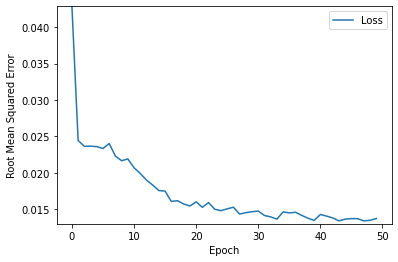

In [36]:
# Gather the trained model's weight and bias.
trained_weight = model2.get_weights()[0]
trained_bias = model2.get_weights()[1]

  # The list of epochs is stored separately from the 
  # rest of history.
epochs = history.epoch
  
  # Gather the history (a snapshot) of each epoch.
#hist = pd.DataFrame(history.history)

  # Specifically gather the model's root mean 
  # squared error at each epoch. 
rmse = history.history["mean_squared_error"]

#plot_the_model(trained_weight, trained_bias, X_test, Y_train)
plot_the_loss_curve(epochs, rmse)

##### Step 5 - Print Performance Summary

In [37]:
print("")
print('-------------------- Model Summary --------------------')
model2.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
print("Too many parameters to print but you can use the code provided if needed")
print("")
#for layer in model.layers:
#    print(layer.name)
#    for item in layer.get_weights():
#        print("  ", item)
#print("")

# Print the last value in the evaluation metrics contained within history file
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")

# Evaluate the model on the test data using "evaluate"
print('-------------------- Evaluation on Test Data --------------------')
results = model2.evaluate(X_test, Y_test)
print("")


-------------------- Model Summary --------------------
Model: "biLSTM-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-LSTM-Encoder-Layer (  (None, 128)              34816     
 Bidirectional)                                                  
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 10, 128)          0         
 Vector)                                                         
                                                                 
 Hidden-LSTM-Decoder-Layer (  (None, 10, 128)          98816     
 Bidirectional)                                                  
                                                                 
 Output-Layer (TimeDistribut  (None, 10, 1)            129       
 ed)                                                             
                                                               

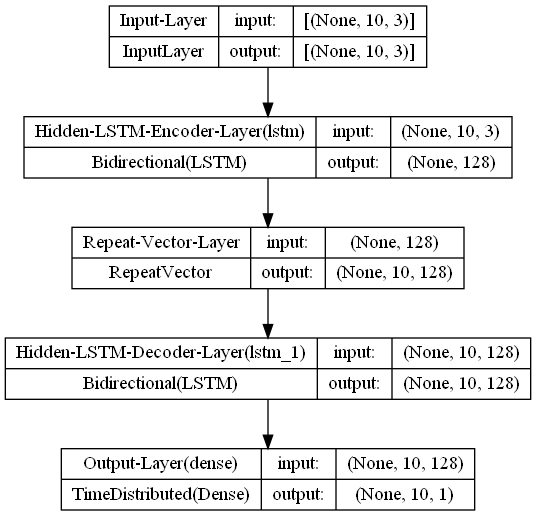

In [38]:
from keras.utils import plot_model,model_to_dot
plot_model(model2, show_shapes=True, to_file='plotmodelbilstm0810.png')


In [39]:
model_to_dot(model2,show_shapes=True)


In [40]:
model2